<a href="https://colab.research.google.com/github/nhahub/NHA-046/blob/main/Crop_Recommendation_week_7%268.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installation

In [44]:
!pip install dagshub
!pip install mlflow

# **Import Libraries**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [46]:
# ML Libraries
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_score, recall_score)

In [47]:
# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import dagshub

In [48]:
# Utils
import joblib
import json
from datetime import datetime
import os

# **Exploratory Data Analysis (EDA)**

### **Load Dataset**

In [49]:
df = pd.read_csv('/content/Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [50]:
print(f"Shape: {df.shape}")
print(f"\nData types:")
df.info()

Shape: (2200, 8)

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [51]:
print(f"Statistical summary:")
df.describe()

Statistical summary:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


There are no extreme values in the data

In [52]:
print("Data quality check")
print(f"Missing values:\n{df.isna().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")

Data quality check
Missing values:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Duplicate rows: 0


Dataset is clean with no missing values or duplicates

In [53]:
# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Target distribution
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64


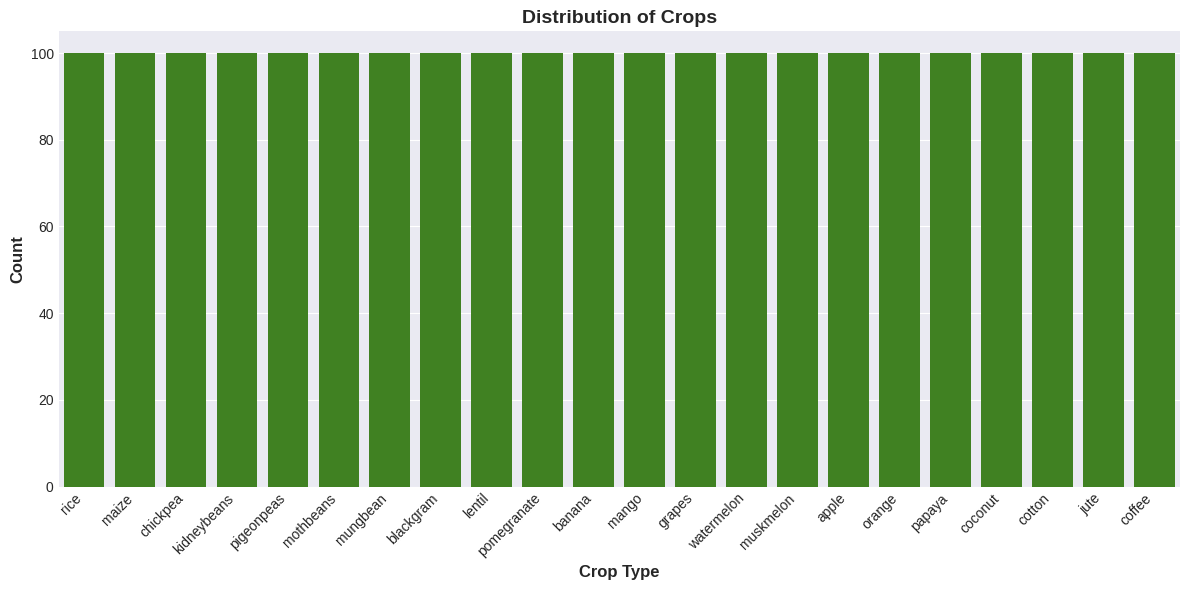

In [54]:
# Target distribution
print("Target distribution")
print(df['label'].value_counts())

plt.figure(figsize=(12, 6))
label_counts = df['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, color='#3A9112')
plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Distribution of Crops', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Insight:** Dataset is well-balanced across all 22 crop types

Feature distributions


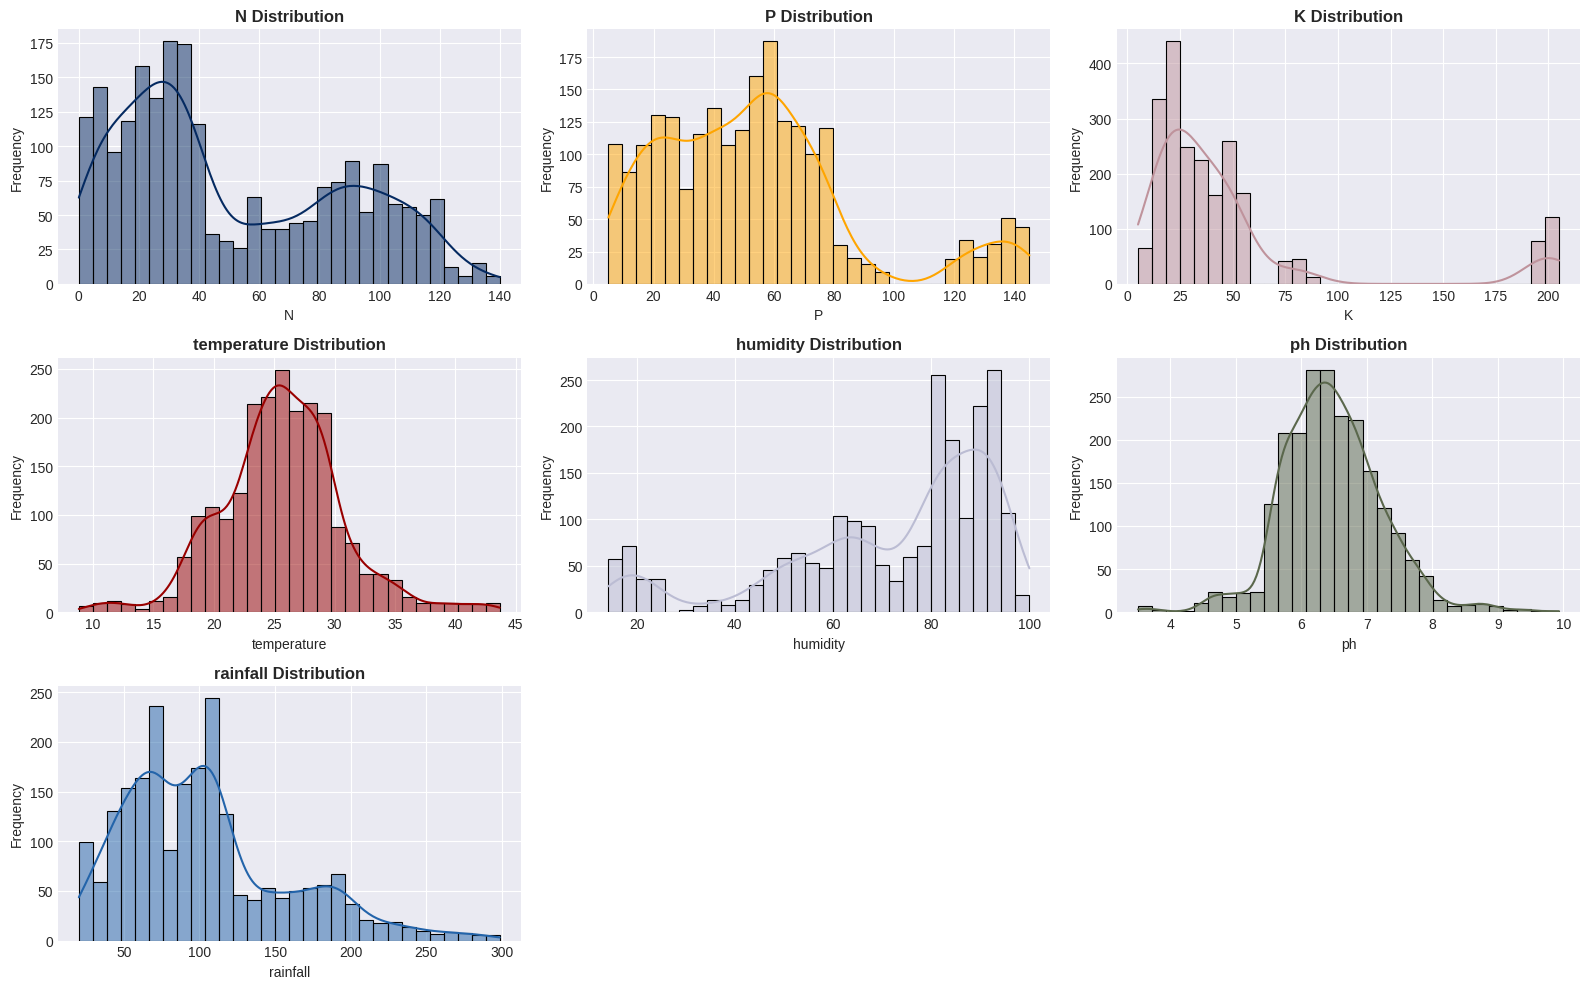

In [55]:
# Feature distributions
print("Feature distributions")

num_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
feature_colors = {
    'N': '#052A61', 'P': '#FFA500', 'K': '#bf939c',
    'temperature': '#990000', 'humidity': '#BBBCD3',
    'ph': '#5a674c', 'rainfall': '#2364AA'
}

plt.figure(figsize=(16, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color=feature_colors[col])
    plt.title(f'{col} Distribution', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### **Key Insights:**
- **Temperature:** Normally distributed (20-30°C)
- **Humidity:** Multi-modal distribution (varies by season/location)
- **pH:** Normally distributed (5.5-7.5, mostly neutral)
- **N & P:** Multi-modal distributions
- **K**: Right-skewed (most values 20-50)
- **Rainfall:** Right-skewed with some extreme values (not outliers, real weather)

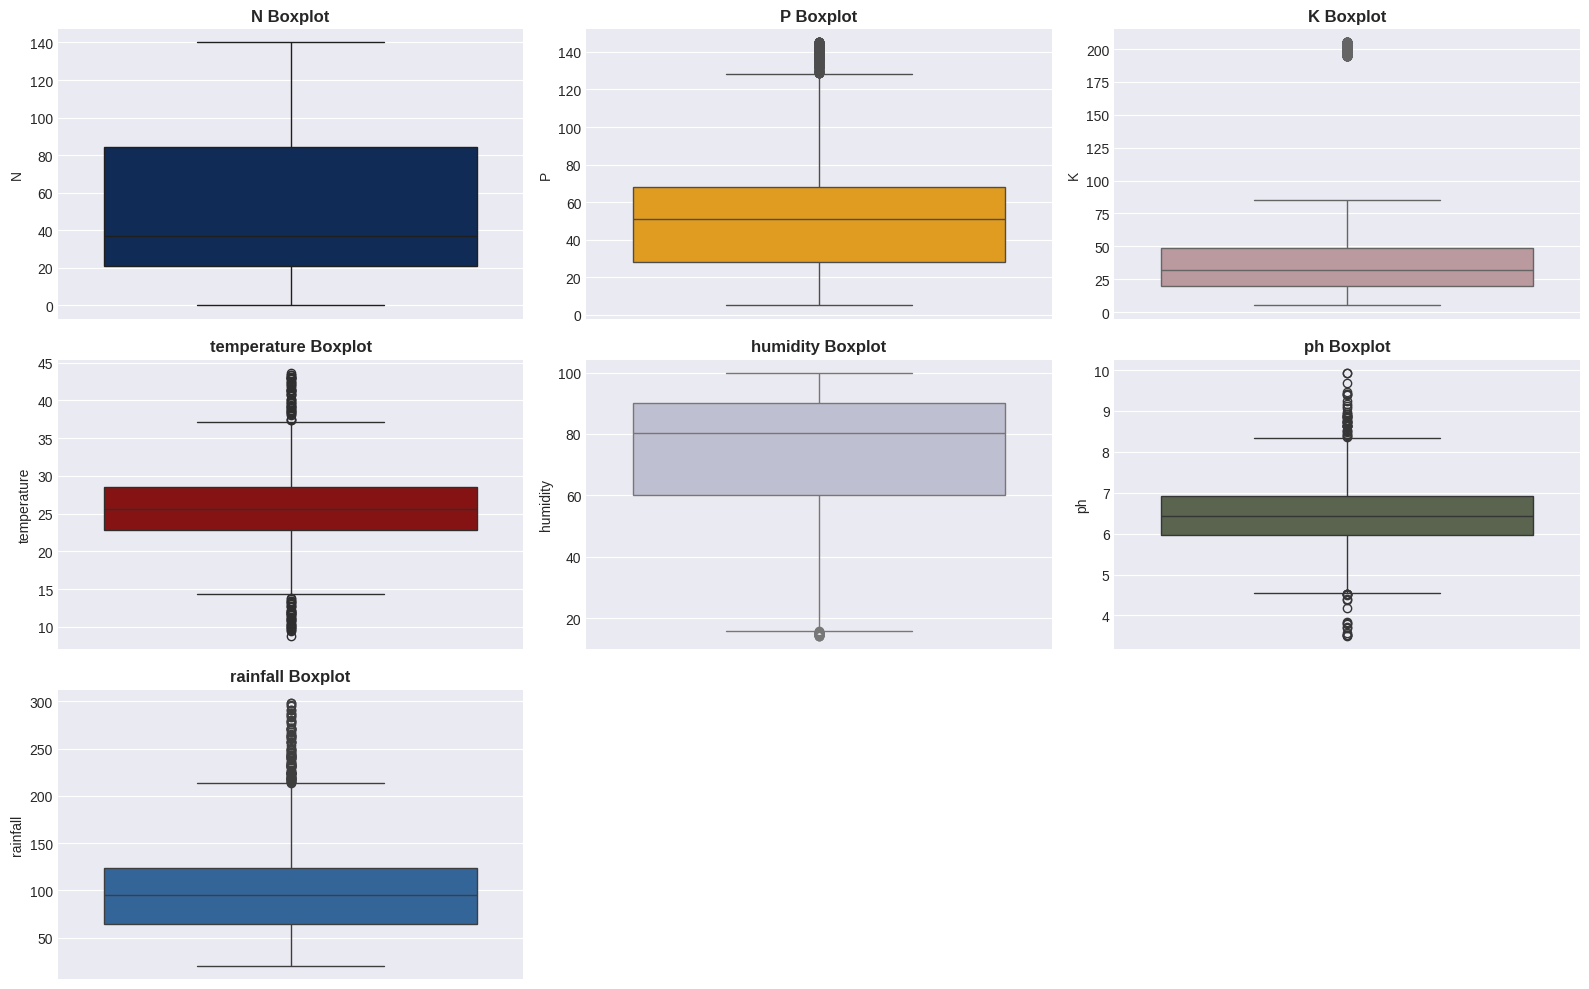

In [56]:
# Box Plots for Outlier Detection
plt.figure(figsize=(16, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color=feature_colors[col])
    plt.title(f'{col} Boxplot', fontweight='bold')
plt.tight_layout()
plt.show()

### **Insight:** Some extreme values represent real weather conditions

NPK Analysis by Crop


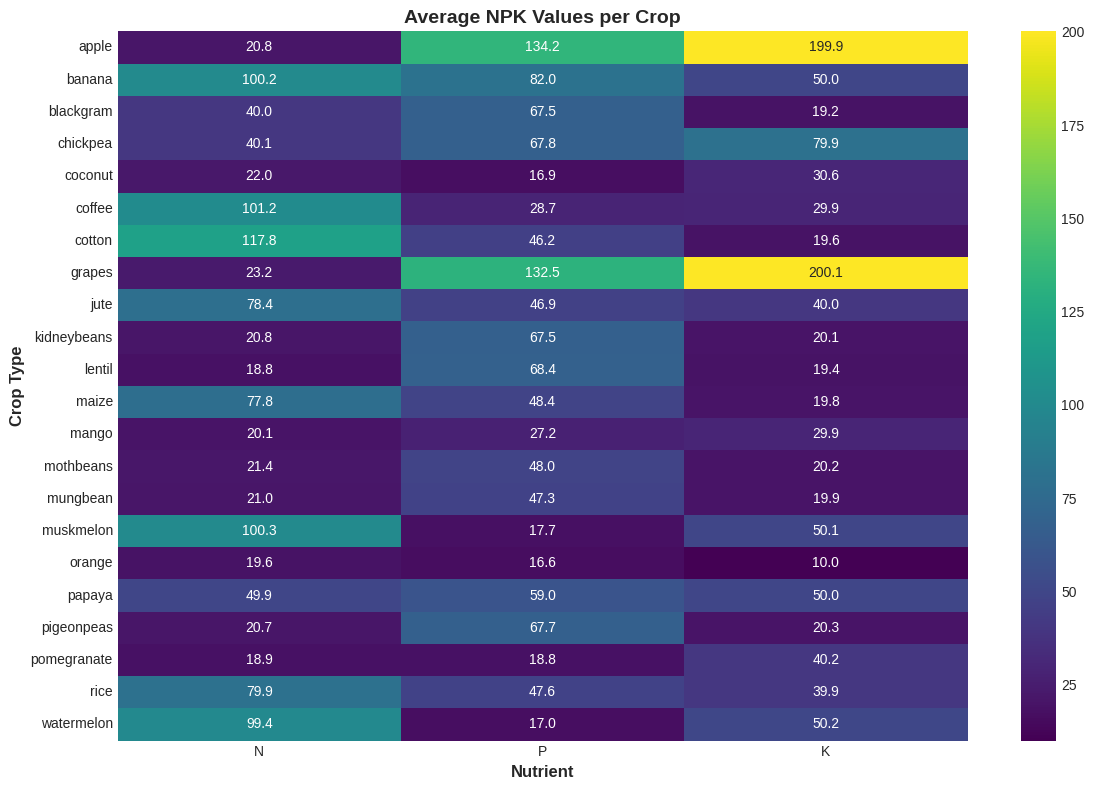

In [57]:
# NPK Heatmap by Crop
print("NPK Analysis by Crop")

avg_npk = df.groupby("label")[['N', 'P', 'K']].mean()
plt.figure(figsize=(12, 8))
sns.heatmap(avg_npk, annot=True, cmap="viridis", fmt='.1f', cbar=True)
plt.title("Average NPK Values per Crop", fontsize=14, fontweight='bold')
plt.ylabel("Crop Type", fontsize=12, fontweight='bold')
plt.xlabel("Nutrient", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### **Insight:** Different crops have similar NPK requirements
Similar: apple & grapes, mothbeans & mungbeans, kidneybeans & lentil

<Figure size 1400x600 with 0 Axes>

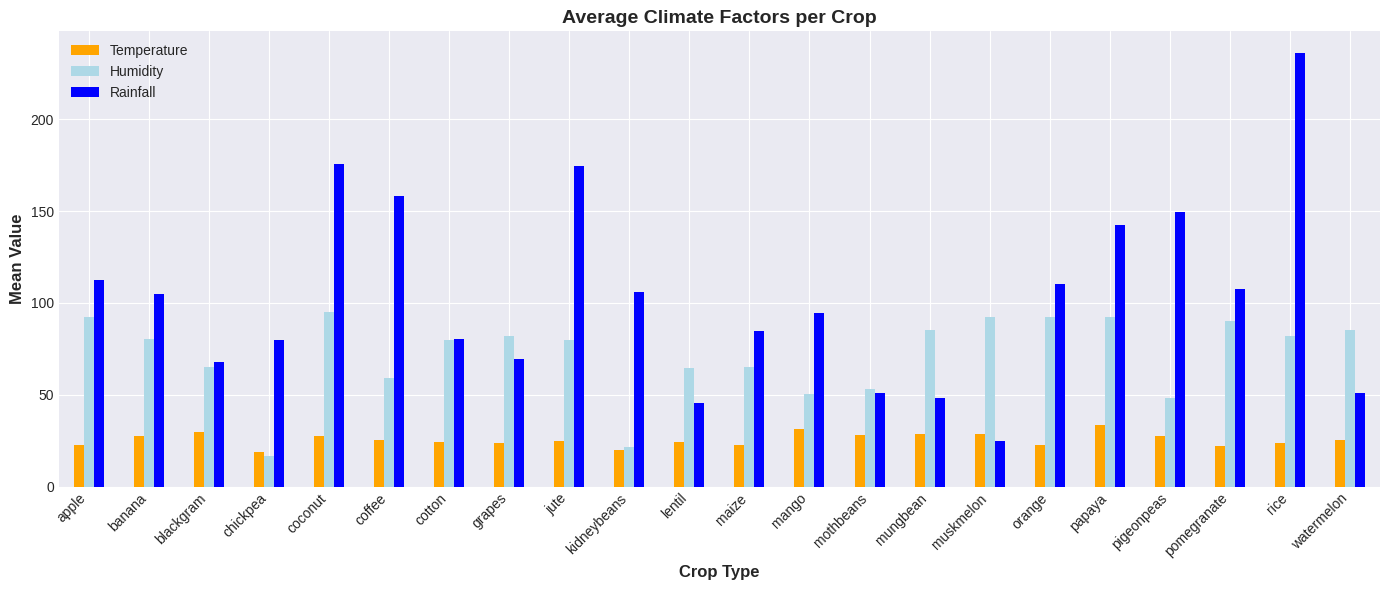

In [58]:
# Climate Factors by Crop
plt.figure(figsize=(14, 6))
avg_climate = df.groupby("label")[['temperature', 'humidity', 'rainfall']].mean()
avg_climate.plot(kind="bar", figsize=(14, 6), color=['orange', 'lightblue', 'blue'])
plt.title("Average Climate Factors per Crop", fontsize=14, fontweight='bold')
plt.ylabel("Mean Value", fontsize=12, fontweight='bold')
plt.xlabel("Crop Type", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(['Temperature', 'Humidity', 'Rainfall'])
plt.tight_layout()
plt.show()

### **Key Insights:**
- **Temperature:** Most crops (e.g., apple, banana) average 20-40°C.
- **Humidity:** Ranges 50-100% across crops, with apples and bananas at ~ 100%, favoring humid-tolerant crops like rice, while drier crops like cotton show lower values (~50%).
- **Rainfall:** Highly variable, from ~50 mm (lentil) to >200 mm (rice, pomegranate), suggesting rice and water-intensive crops thrive in high-rainfall areas, while others need irrigation.

**Crop Suitability:** High rainfall and humidity favor rice and pomegranate; moderate conditions suit apples, bananas, and grapes; low rainfall crops like lentil need drought-resistant strategies.

Feature Relationships


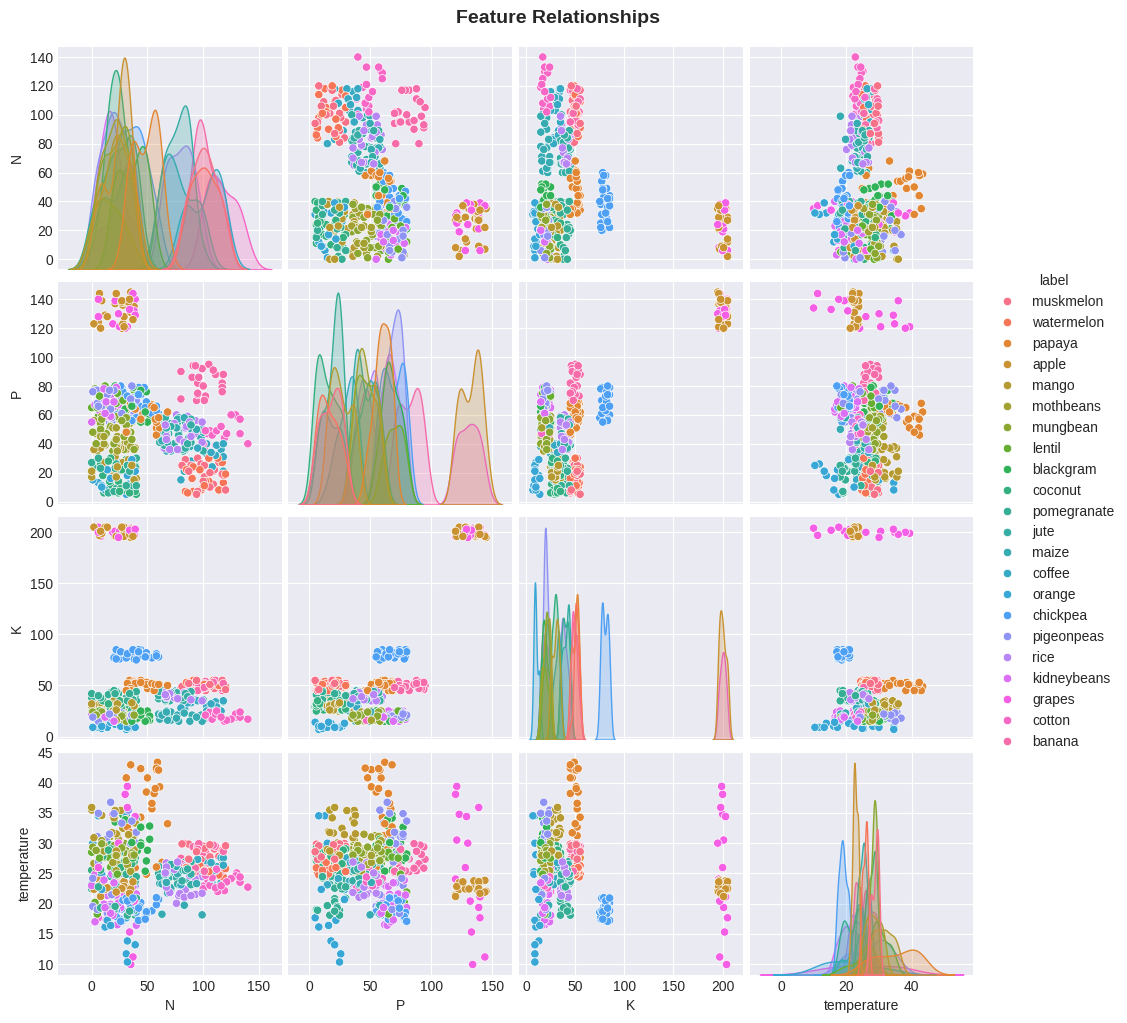

In [59]:
# Pairplot (Sample)
print("Feature Relationships")

sample_df = df.sample(500, random_state=42)
sns.pairplot(sample_df,
             hue="label",
             vars=['N', 'P', 'K', 'temperature'],
             diag_kind='kde')
plt.suptitle("Feature Relationships", y=1.02, fontsize=14, fontweight='bold')
plt.show()

### **Insight:** Crops form distinct clusters based on nutrient and climate needs

# **Preprocessing**

## **Feature Engineering**

In [60]:
# Create new features
df['NPK_Avg_Soil_Fertility'] = (df['N'] + df['P'] + df['K']) / 3
df['THI'] = (df['temperature'] * df['humidity']) / 100
df['NP_Ratio'] = df['N'] / df['P']
df['KP_Ratio'] = df['K'] / df['P']
df['temp_rain'] = df['temperature'] * df['rainfall']
df['ph_rain'] = df['ph'] * df['rainfall']

In [61]:
# Categorical features
df['ph_category'] = df['ph'].apply(
    lambda x: 'Acidic' if x < 5.5 else ('Neutral' if x <= 7.5 else 'Alkaline')
)
df['rainfall_level'] = pd.cut(df['rainfall'],
                               bins=[0, 50, 100, 200, 300],
                               labels=['Low', 'Medium', 'High', 'Very High'])

Created 8 new features:
1. NPK_Avg_Soil_Fertility - Overall soil nutrient level
2. THI - Temperature-Humidity Index
3. NP_Ratio - Nitrogen to Phosphorus balance
4. KP_Ratio - Potassium to Phosphorus balance
5. temp_rain - Temperature × Rainfall interaction
6. ph_rain - pH × Rainfall interaction
7. ph_category - Acidic/Neutral/Alkaline
8. rainfall_level - Low/Medium/High/Very High

In [62]:
print(f"New dataset shape: {df.shape}")
df.head()

New dataset shape: (2200, 16)


,N,P,K,temperature,humidity,ph,rainfall,label,NPK_Avg_Soil_Fertility,THI,NP_Ratio,KP_Ratio,temp_rain,ph_rain,ph_category,rainfall_level
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,58.333333,17.121963,2.142857,1.023810,4237.241986,1319.686807,Neutral,Very High
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,61.333333,17.485957,1.465517,0.706897,4934.395694,1595.223513,Neutral,Very High
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,53.000000,18.937446,1.090909,0.800000,6072.354751,2069.534380,Alkaline,Very High
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,49.666667,21.234829,2.114286,1.142857,6433.734530,1695.288324,Neutral,Very High
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,54.000000,16.427204,1.857143,1.000000,5288.545993,2004.132110,Alkaline,Very High


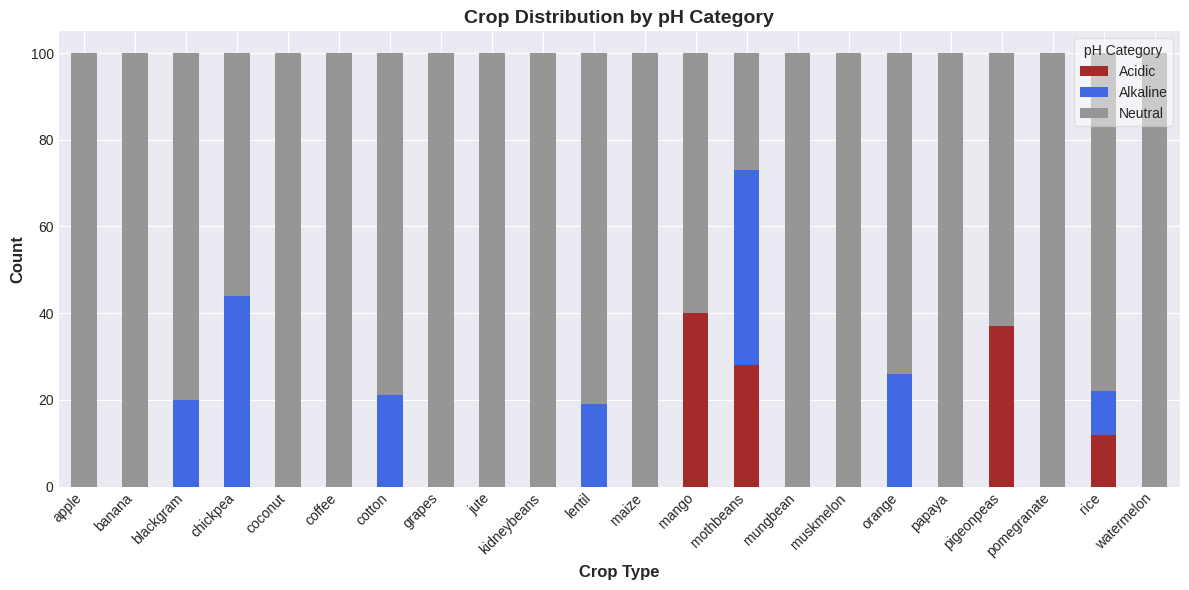

In [63]:
# pH Category Analysis
label_ph = df.groupby(['label', 'ph_category']).size().unstack(fill_value=0)
colors_ph = {'Acidic': '#A52A2A', 'Neutral': '#969696', 'Alkaline': '#4169E1'}
label_ph.plot(kind='bar', stacked=True, figsize=(12, 6),
              color=[colors_ph[col] for col in label_ph.columns])
plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Crop Distribution by pH Category', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title="pH Category", facecolor="white",framealpha=0.5, frameon=True)
plt.tight_layout()
plt.show()

### **Insight:** Most crops prefer neutral soil (pH 5.5-7.5)

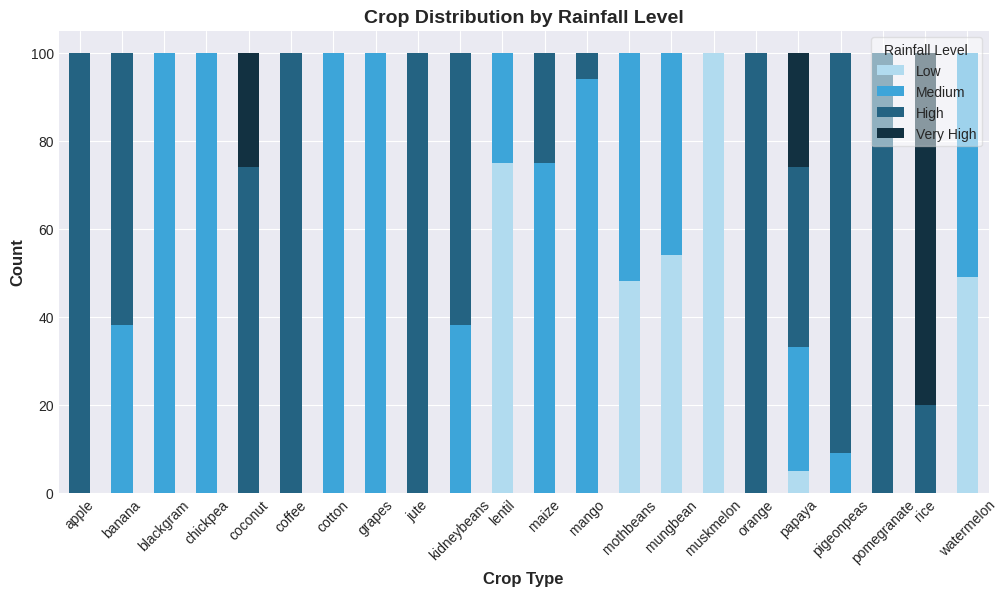

In [64]:
# Rainfall Level Analysis
label_rain = df.groupby(['label', 'rainfall_level']).size().unstack(fill_value=0)

colors_rain = {'Low': '#b1dbef', 'Medium': '#3da5d9',
               'High': '#246382', 'Very High': '#123141'}

label_rain.plot(kind='bar', stacked=True, figsize=(12, 6),
                color=[colors_rain[col] for col in label_rain.columns])

plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Crop Distribution by Rainfall Level', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title="Rainfall Level", loc='best', facecolor="white",framealpha=0.5, frameon=True)
plt.show()

### **Key Insights:**
- Rainfall is a strong predictor of crop type
- Some crops (apple, jute, orange) depend on high rainfall
- Others (papaya, banana) show high variability (less sensitive)

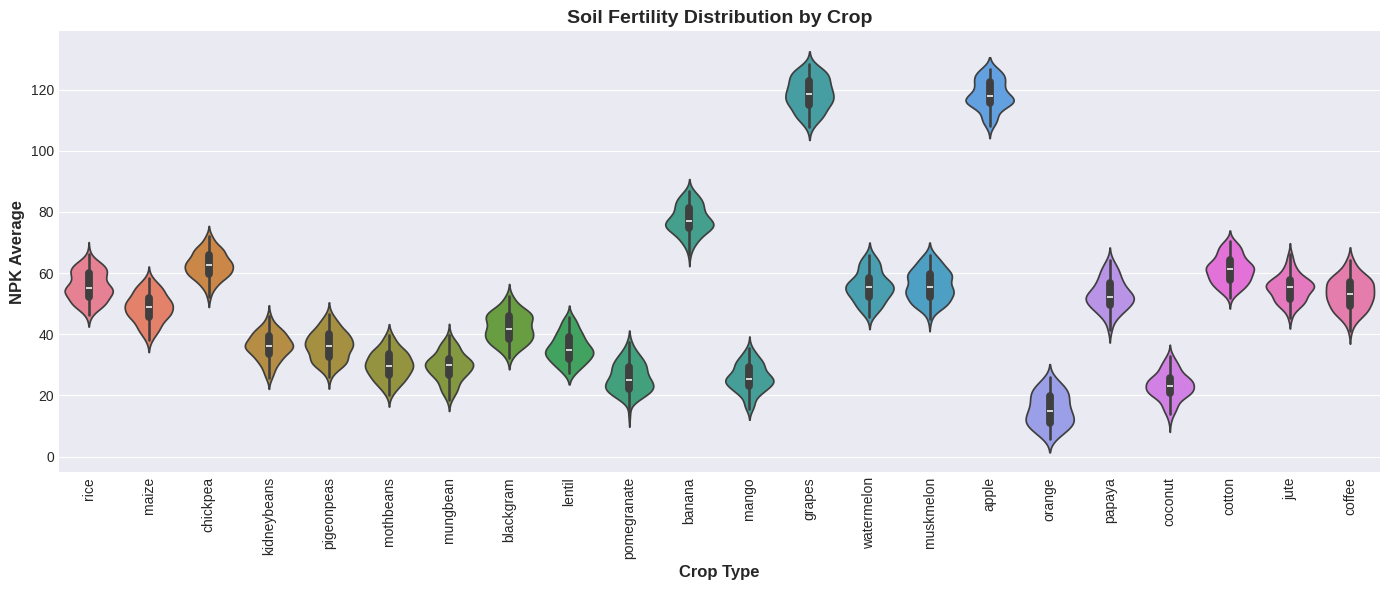

In [65]:
# Soil Fertility Distribution
plt.figure(figsize=(14, 6))
sns.violinplot(x="label", y="NPK_Avg_Soil_Fertility",
               data=df, inner="box", palette='husl')
plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('NPK Average', fontsize=12, fontweight='bold')
plt.title('Soil Fertility Distribution by Crop', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.title("Soil Fertility Distribution by Crop", fontsize=14, fontweight='bold')
plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('NPK Average', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### **Key Insights:**
- Wide violins = crop tolerates diverse soil conditions
- Narrow violins = crop needs specific soil fertility

## **Encode Categorical Variables**

In [66]:
from sklearn.preprocessing import LabelEncoder

# encoder for the label
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# encoders for the rest
ph_encoder = LabelEncoder()
rainfall_encoder = LabelEncoder()

df['ph_category'] = ph_encoder.fit_transform(df['ph_category'])
df['rainfall_level'] = rainfall_encoder.fit_transform(df['rainfall_level'])


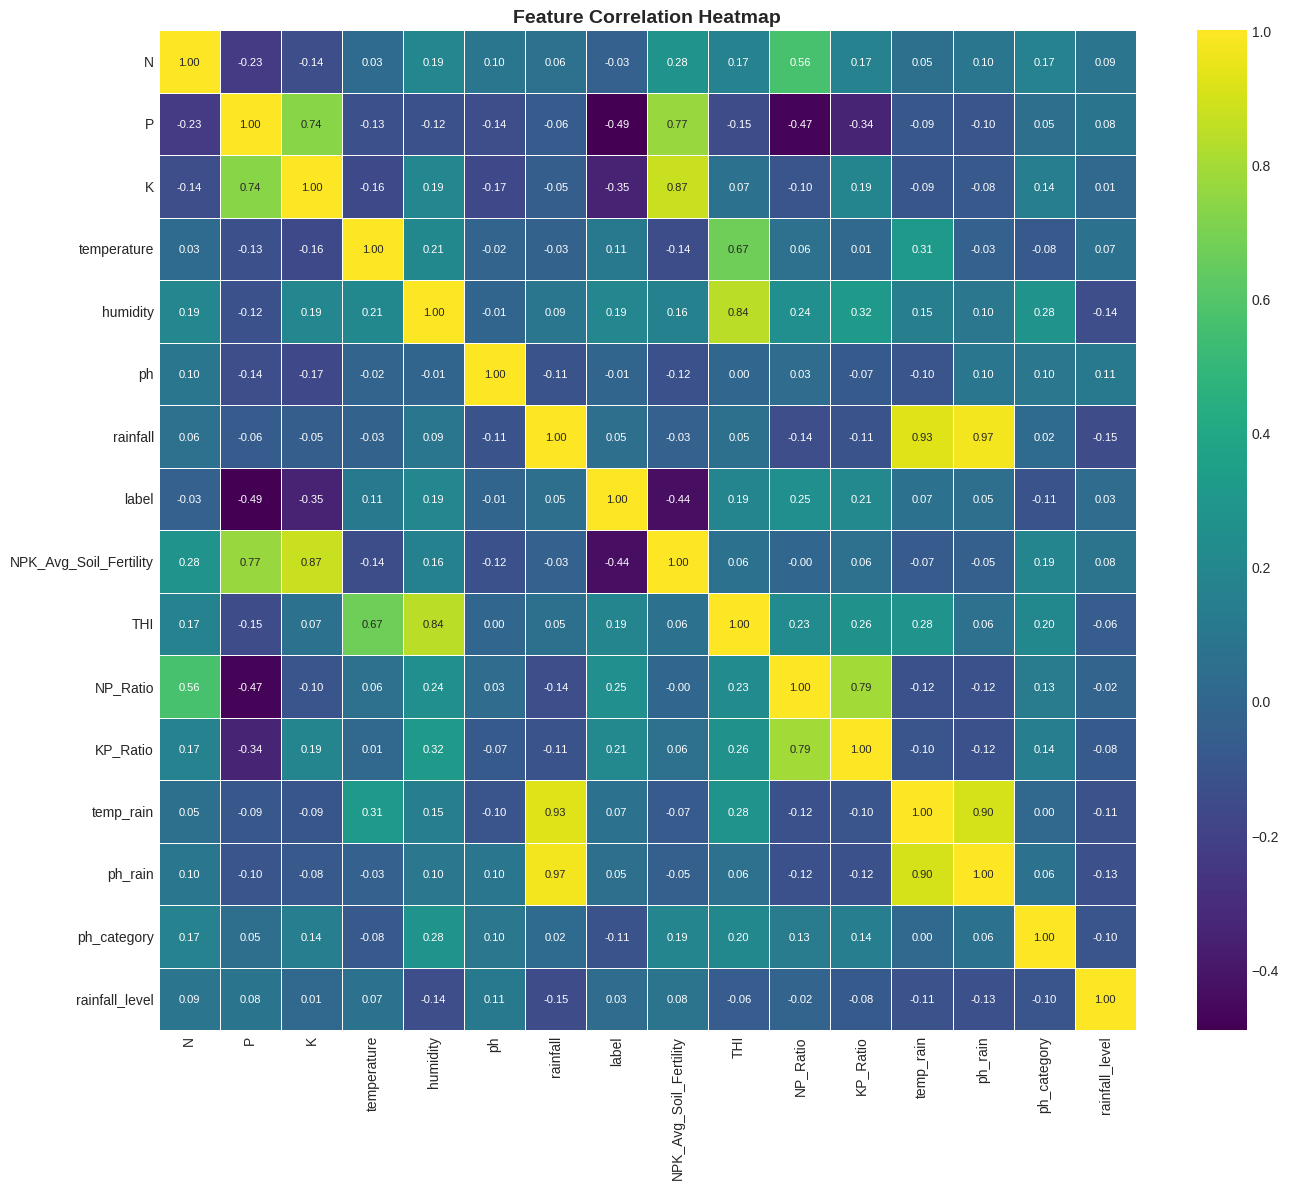

In [67]:
# Correlation Analysis
plt.figure(figsize=(14, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f",
            annot_kws={"size": 8}, linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### **Insight:** Strong correlation between(NPK_Avg_Soil_Fertility, P, K) and the target.

## **Feature Selection**

In [68]:
X = df.drop(['label'], axis=1)
y = df['label']

# Chi-Square Test

selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X, y)

chi2_scores = pd.DataFrame({
    "Feature": X.columns,
    "Chi2 Score": selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

print("Chi-Square Scores:")
print(chi2_scores.to_string(index=False))

Chi-Square Scores:
               Feature   Chi2 Score
             temp_rain 1.528748e+06
               ph_rain 3.457020e+05
                     K 1.167105e+05
              rainfall 5.480813e+04
                     N 5.314470e+04
                     P 4.250013e+04
NPK_Avg_Soil_Fertility 2.981838e+04
              humidity 1.475549e+04
              NP_Ratio 5.327409e+03
                   THI 4.706916e+03
              KP_Ratio 1.992507e+03
        rainfall_level 1.219287e+03
           temperature 1.092422e+03
           ph_category 1.053688e+02
                    ph 7.488657e+01


In [69]:
# Select top 10 features based on Chi2
top_10_features = chi2_scores.head(10)['Feature'].tolist()

print("Top 10 Selected Features:")
for i, feat in enumerate(top_10_features, 1):
    score = chi2_scores[chi2_scores['Feature'] == feat]['Chi2 Score'].values[0]
    print(f"  {i}. {feat}: {score:.2e}")

Top 10 Selected Features:
  1. temp_rain: 1.53e+06
  2. ph_rain: 3.46e+05
  3. K: 1.17e+05
  4. rainfall: 5.48e+04
  5. N: 5.31e+04
  6. P: 4.25e+04
  7. NPK_Avg_Soil_Fertility: 2.98e+04
  8. humidity: 1.48e+04
  9. NP_Ratio: 5.33e+03
  10. THI: 4.71e+03


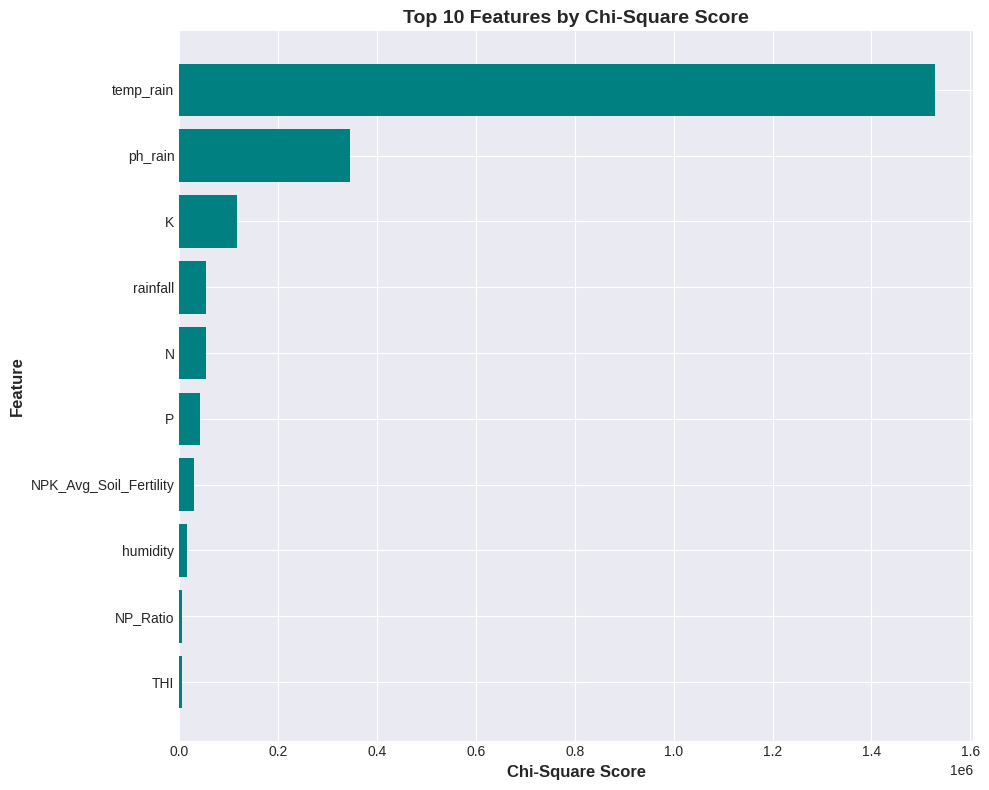

In [70]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = chi2_scores.head(10)
plt.barh(top_features['Feature'], top_features['Chi2 Score'], color='teal')
plt.xlabel('Chi-Square Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 10 Features by Chi-Square Score', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# **Modeling**

## **Prepare Data For Modeling**

In [71]:
# Use top 10 features
X = df[top_10_features]
y = df['label']

In [72]:
# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1540, 10)
Validation set: (330, 10)
Test set: (330, 10)


In [73]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## **MlFlow with Dagshub**

In [74]:
# Initialize DagsHub
dagshub.init(repo_owner='selvia.nasser19', repo_name='crop-recommendation', mlflow=True)
mlflow.set_experiment("crop_recommendation_models")

Initialized MLflow to track repo "selvia.nasser19/crop-recommendation"

Repository selvia.nasser19/crop-recommendation initialized!

<Experiment: artifact_location='mlflow-artifacts:/604aa7fb883140e1a734c685c909baa5', creation_time=1759182748678, experiment_id='1', last_update_time=1759182748678, lifecycle_stage='active', name='crop_recommendation_models', tags={}>

## **Initial Training**

In [75]:
# Baseline Models (Before Optimization)
baseline_models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    ),
    "SVM": SVC(probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

baseline_results = []

for model_name, model in baseline_models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    baseline_results.append({
        'Model': model_name,
        'Baseline_Acc': val_acc,
        'Baseline_F1': val_f1
    })

    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Validation F1:       {val_f1:.4f}")

# saving the best model
best_model = baseline_models["XGBoost"]

baseline_df = pd.DataFrame(baseline_results).sort_values('Baseline_Acc', ascending=False)

print("\n" + "="*50)
print("BASELINE RESULTS:")
print(baseline_df.to_string(index=False))



Training RandomForest...
  Validation Accuracy: 0.9879
  Validation F1:       0.9876

Training XGBoost...
  Validation Accuracy: 0.9909
  Validation F1:       0.9909

Training SVM...
  Validation Accuracy: 0.9667
  Validation F1:       0.9660

Training DecisionTree...
  Validation Accuracy: 0.9727
  Validation F1:       0.9724

BASELINE RESULTS:
       Model  Baseline_Acc  Baseline_F1
     XGBoost      0.990909     0.990899
RandomForest      0.987879     0.987609
DecisionTree      0.972727     0.972423
         SVM      0.966667     0.965987


# **Insights**


---


 **XGBoost** achieved the highest baseline accuracy and F1-score.

## **Hyperparameter Tuning with Grid Search**

In [76]:
# Define parameter grids for each model
param_grids = {
    "RandomForest": {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt']
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'reg_alpha': [0, 0.1],      # L1 regularization
        'reg_lambda': [1]             # L2 regularization
    },
    "SVM": {
        'C': [1, 10, 50],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    },
    "DecisionTree": {
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', None],
        'ccp_alpha': [0.0, 0.01]  # Pruning
    }
}

In [77]:
best_models = {}
grid_search_results = []

for model_name in baseline_models.keys():
    print(f"Grid Search: {model_name}")
    print(f"{'='*50}")

    # Create separate experiment for each model
    mlflow.set_experiment(experiment_name=f"{model_name}_Experiment")

    with mlflow.start_run(run_name=f"{model_name}_GridSearch"):

        mlflow.log_param("optimization_type", "GridSearch")
        mlflow.log_param("model_type", model_name)

        # Initialize model
        if model_name == "XGBoost":
            base_model = XGBClassifier(
                objective='multi:softmax',
                num_class=len(np.unique(y_train)),
                random_state=42,
                n_jobs=-1,
                eval_metric='mlogloss'
            )
        else:
            base_model = baseline_models[model_name]

        # Grid Search
        print(f"Parameter grid: {list(param_grids[model_name].keys())}")
        print(f"Starting Grid Search...")

        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grids[model_name],
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train_scaled, y_train)

        # Best parameters
        print(f"\n Best parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"  • {param}: {value}")
            mlflow.log_param(f"best_{param}", value)

        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model

        # Evaluate on validation set
        y_val_pred = best_model.predict(X_val_scaled)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='macro')

        print(f"\n Validation Results:")
        print(f"  • Accuracy: {val_acc:.4f}")
        print(f"  • F1-Score: {val_f1:.4f}")
        print(f"  • CV Score: {grid_search.best_score_:.4f}")

        mlflow.log_metric("val_accuracy", val_acc)
        mlflow.log_metric("val_f1", val_f1)
        mlflow.log_metric("cv_score", grid_search.best_score_)

        # Calculate improvement
        baseline_row = baseline_df[baseline_df['Model'] == model_name]
        baseline_acc = baseline_row['Baseline_Acc'].values[0] if len(baseline_row) > 0 else 0.0
        improvement = val_acc - baseline_acc
        mlflow.log_metric("improvement", improvement)

        grid_search_results.append({
            'Model': model_name,
            'Baseline': baseline_acc,
            'Optimized': val_acc,
            'Improvement': improvement,
            'F1': val_f1
        })

        # Log model
        try:
            if model_name == "XGBoost":
                mlflow.xgboost.log_model(best_model, artifact_path="model")
            else:
                mlflow.sklearn.log_model(best_model, artifact_path="model")
        except Exception as e:
            print(f"!! Model logging skipped: {e} !!")

grid_df = pd.DataFrame(grid_search_results).sort_values('Optimized', ascending=False)
print("\n" + grid_df.to_string(index=False))


Grid Search: RandomForest
Parameter grid: ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
Starting Grid Search...

 Best parameters:
  • max_depth: 15
  • max_features: sqrt
  • min_samples_leaf: 1
  • min_samples_split: 5
  • n_estimators: 200

 Validation Results:
  • Accuracy: 0.9879
  • F1-Score: 0.9877
  • CV Score: 0.9903


2025/11/17 19:11:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


!! Model logging skipped: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'} !!
🏃 View run RandomForest_GridSearch at: https://dagshub.com/selvia.nasser19/crop-recommendation.mlflow/#/experiments/2/runs/095b366e3d1248af9f92b13721778c18
🧪 View experiment at: https://dagshub.com/selvia.nasser19/crop-recommendation.mlflow/#/experiments/2
Grid Search: XGBoost
Parameter grid: ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']
Starting Grid Search...

 Best parameters:
  • colsample_bytree: 0.8
  • learning_rate: 0.05
  • max_depth: 5
  • n_estimators: 200
  • reg_alpha: 0.1
  • reg_lambda: 1
  • subsample: 0.8

 Validation Results:
  • Accuracy: 0.9939
  • F1-Score: 0.9939
  • CV Score: 0.9864


2025/11/17 19:11:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


!! Model logging skipped: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'} !!
🏃 View run XGBoost_GridSearch at: https://dagshub.com/selvia.nasser19/crop-recommendation.mlflow/#/experiments/3/runs/9b1655bccd5a4cf7a8fe497562777d29
🧪 View experiment at: https://dagshub.com/selvia.nasser19/crop-recommendation.mlflow/#/experiments/3
Grid Search: SVM
Parameter grid: ['C', 'kernel', 'gamma']
Starting Grid Search...

 Best parameters:
  • C: 10
  • gamma: scale
  • kernel: rbf

 Validation Results:
  • Accuracy: 0.9848
  • F1-Score: 0.9849
  • CV Score: 0.9812


2025/11/17 19:11:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


!! Model logging skipped: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'} !!
🏃 View run SVM_GridSearch at: https://dagshub.com/selvia.nasser19/crop-recommendation.mlflow/#/experiments/4/runs/4650806b6c5543a9b52a8ba46a065908
🧪 View experiment at: https://dagshub.com/selvia.nasser19/crop-recommendation.mlflow/#/experiments/4
Grid Search: DecisionTree
Parameter grid: ['max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'ccp_alpha']
Starting Grid Search...

 Best parameters:
  • ccp_alpha: 0.0
  • max_depth: 15
  • max_features: None
  • min_samples_leaf: 1
  • min_samples_split: 2

 Validation Results:
  • Accuracy: 0.9758
  • F1-Score: 0.9755
  • CV Score: 0.9818


2025/11/17 19:12:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


!! Model logging skipped: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'} !!
🏃 View run DecisionTree_GridSearch at: https://dagshub.com/selvia.nasser19/crop-recommendation.mlflow/#/experiments/5/runs/c286b3e3f71e4564b34c02ef3895a8a0
🧪 View experiment at: https://dagshub.com/selvia.nasser19/crop-recommendation.mlflow/#/experiments/5

       Model  Baseline  Optimized  Improvement       F1
     XGBoost  0.990909   0.993939     0.003030 0.993933
RandomForest  0.987879   0.987879     0.000000 0.987733
         SVM  0.966667   0.984848     0.018182 0.984906
DecisionTree  0.972727   0.975758     0.003030 0.975518


# **Insights**


---


 **XGBoost** remained the top performer after optimization, showing both high accuracy and stability across folds.

## **Compare Baseline VS Optimized**

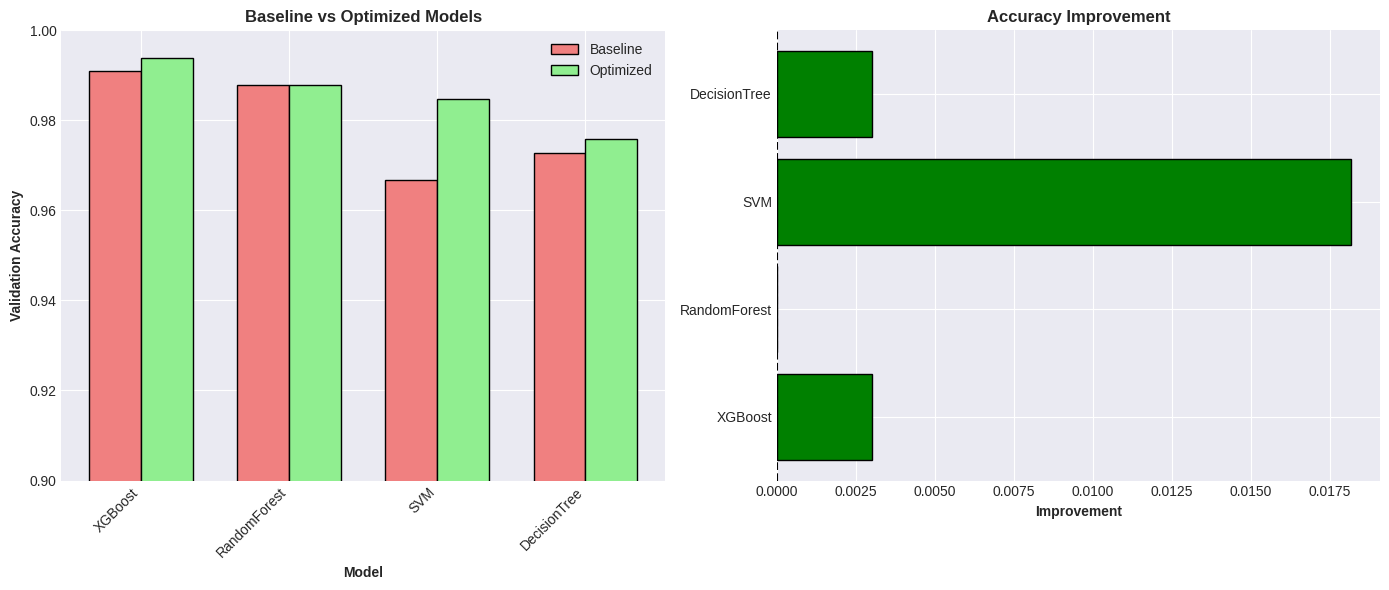

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Comparison plot
x = np.arange(len(grid_df))
width = 0.35
axes[0].bar(x - width/2, grid_df['Baseline'], width,
            label='Baseline', color='lightcoral', edgecolor='black')
axes[0].bar(x + width/2, grid_df['Optimized'], width,
            label='Optimized', color='lightgreen', edgecolor='black')
axes[0].set_xlabel('Model', fontweight='bold')
axes[0].set_ylabel('Validation Accuracy', fontweight='bold')
axes[0].set_title('Baseline vs Optimized Models', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(grid_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0.9, 1.0])

# Improvement plot
colors = ['green' if imp > 0 else 'red' for imp in grid_df['Improvement']]
axes[1].barh(grid_df['Model'], grid_df['Improvement'], color=colors, edgecolor='black')
axes[1].set_xlabel('Improvement', fontweight='bold')
axes[1].set_title('Accuracy Improvement', fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

## **Final Evaluation**

Final Evaluation: RandomForest


2025/11/17 19:12:13 INFO mlflow.tracking.fluent: Experiment with name 'RandomForest_FinalEvaluation' does not exist. Creating a new experiment.


Running 5-fold CV...

 Results:
  • CV Accuracy:    0.9877 (±0.0052)
  • Train Accuracy: 1.0000
  • Val Accuracy:   0.9879
  • Test Accuracy:  1.0000
  • Test F1:        1.0000
  • Test Precision: 1.0000
  • Test Recall:    1.0000
  • Overfit Gap:    0.0000


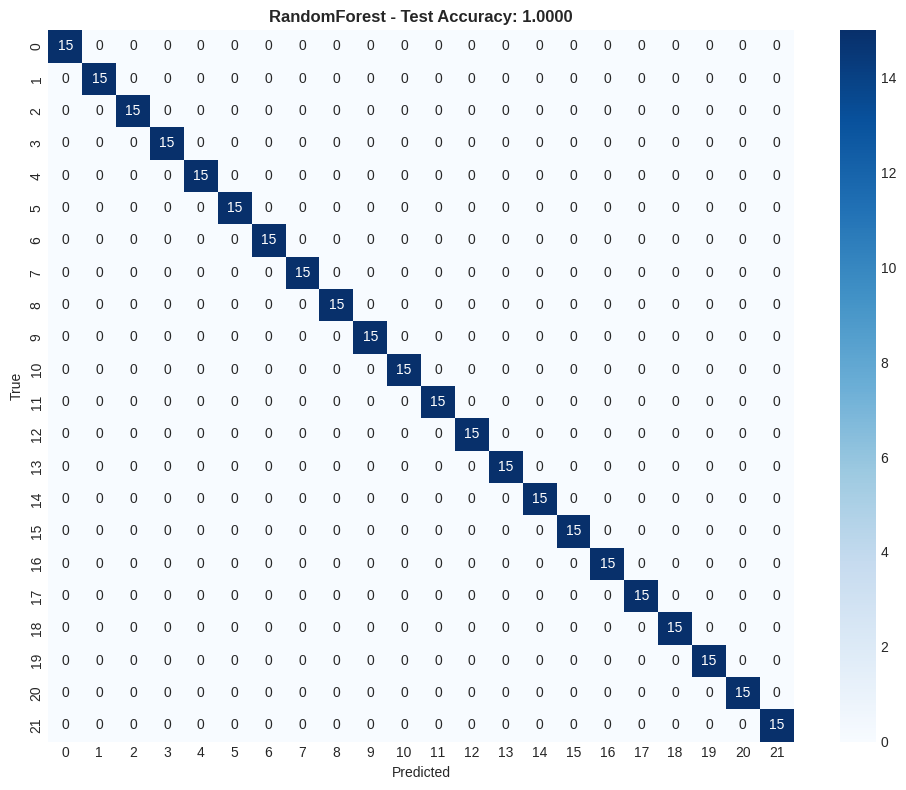

2025/11/17 19:12:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00   

2025/11/17 19:12:32 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_FinalEvaluation' does not exist. Creating a new experiment.


Running 5-fold CV...

 Results:
  • CV Accuracy:    0.9870 (±0.0074)
  • Train Accuracy: 1.0000
  • Val Accuracy:   0.9939
  • Test Accuracy:  1.0000
  • Test F1:        1.0000
  • Test Precision: 1.0000
  • Test Recall:    1.0000
  • Overfit Gap:    0.0000


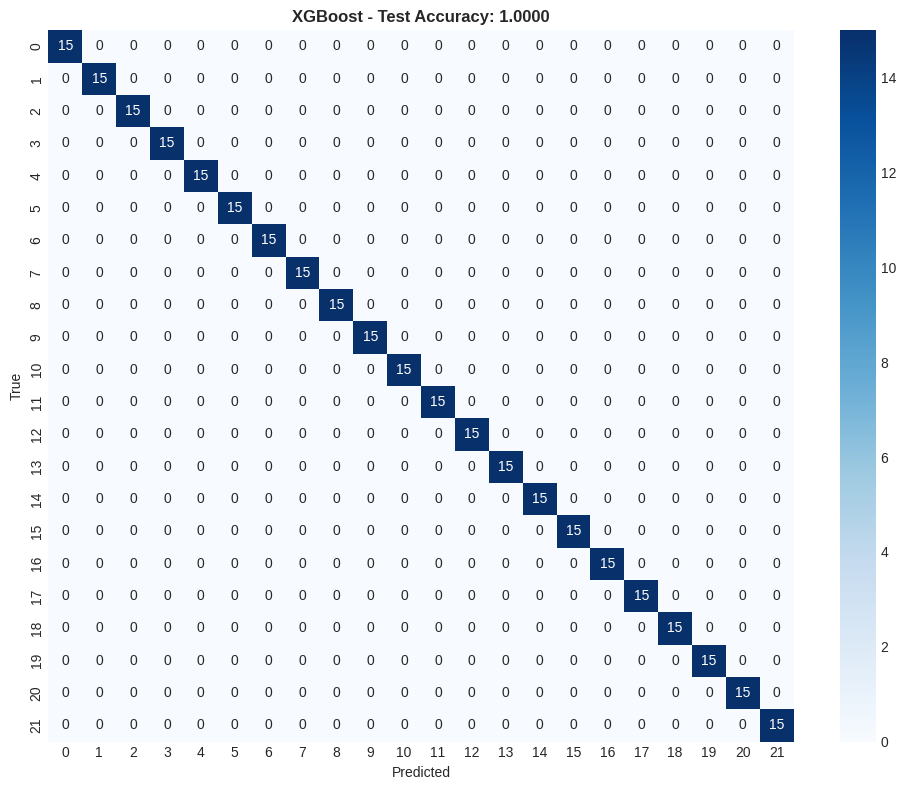

2025/11/17 19:12:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00   

2025/11/17 19:12:49 INFO mlflow.tracking.fluent: Experiment with name 'SVM_FinalEvaluation' does not exist. Creating a new experiment.


Running 5-fold CV...

 Results:
  • CV Accuracy:    0.9812 (±0.0090)
  • Train Accuracy: 0.9896
  • Val Accuracy:   0.9848
  • Test Accuracy:  0.9909
  • Test F1:        0.9909
  • Test Precision: 0.9918
  • Test Recall:    0.9909
  • Overfit Gap:    -0.0013


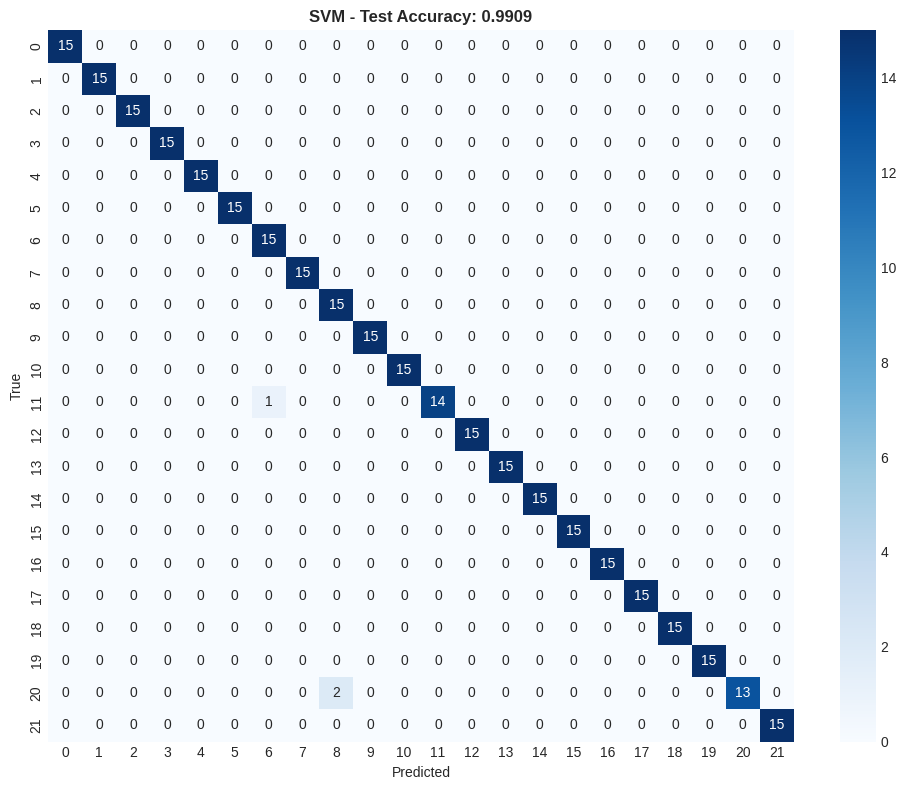

2025/11/17 19:13:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       0.94      1.00      0.97        15
           7       1.00      1.00      1.00        15
           8       0.88      1.00      0.94        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       1.00      0.93      0.97        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00   

2025/11/17 19:13:07 INFO mlflow.tracking.fluent: Experiment with name 'DecisionTree_FinalEvaluation' does not exist. Creating a new experiment.


Running 5-fold CV...

 Results:
  • CV Accuracy:    0.9805 (±0.0105)
  • Train Accuracy: 0.9987
  • Val Accuracy:   0.9758
  • Test Accuracy:  0.9909
  • Test F1:        0.9909
  • Test Precision: 0.9918
  • Test Recall:    0.9909
  • Overfit Gap:    0.0078


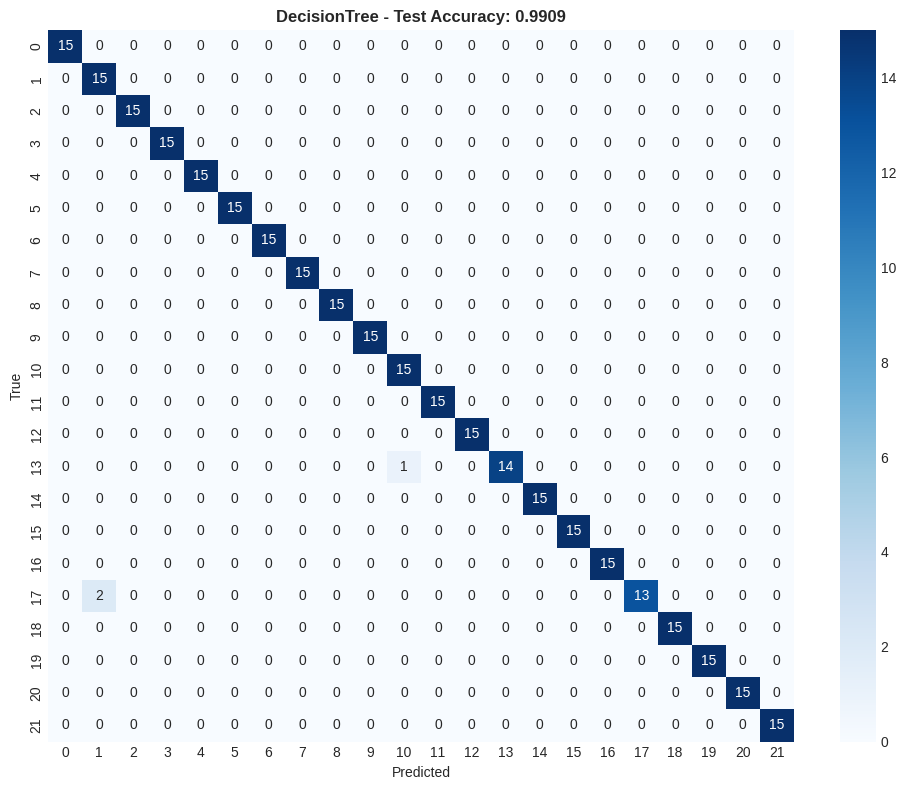

2025/11/17 19:13:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      1.00      0.94        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       0.94      1.00      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      0.93      0.97        15
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00   

In [79]:
final_results = []

for model_name, model in best_models.items():
    print(f"Final Evaluation: {model_name}")
    print(f"{'='*50}")

    mlflow.set_experiment(experiment_name=f"{model_name}_FinalEvaluation")

    with mlflow.start_run(run_name=f"{model_name}_FinalTest"):

        mlflow.log_param("model_type", model_name)
        mlflow.log_param("stage", "final_test")

        # Cross-validation
        print("Running 5-fold CV...")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(
            model, X_train_scaled, y_train,
            cv=cv,
            scoring=['accuracy', 'f1_macro'],
            n_jobs=-1
        )

        cv_acc = cv_results['test_accuracy'].mean()
        cv_std = cv_results['test_accuracy'].std()

        # Train and predict
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)
        y_test_pred = model.predict(X_test_scaled)

        # Metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred, average='macro')
        test_precision = precision_score(y_test, y_test_pred, average='macro')
        test_recall = recall_score(y_test, y_test_pred, average='macro')
        overfit_gap = train_acc - test_acc

        print(f"\n Results:")
        print(f"  • CV Accuracy:    {cv_acc:.4f} (±{cv_std:.4f})")
        print(f"  • Train Accuracy: {train_acc:.4f}")
        print(f"  • Val Accuracy:   {val_acc:.4f}")
        print(f"  • Test Accuracy:  {test_acc:.4f}")
        print(f"  • Test F1:        {test_f1:.4f}")
        print(f"  • Test Precision: {test_precision:.4f}")
        print(f"  • Test Recall:    {test_recall:.4f}")
        print(f"  • Overfit Gap:    {overfit_gap:.4f}")

        # Log metrics
        mlflow.log_metric("cv_accuracy", cv_acc)
        mlflow.log_metric("train_acc", train_acc)
        mlflow.log_metric("val_acc", val_acc)
        mlflow.log_metric("test_acc", test_acc)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("overfit_gap", overfit_gap)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} - Test Accuracy: {test_acc:.4f}', fontweight='bold')
        plt.ylabel('True')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()

        # Classification Report
        report = classification_report(y_test, y_test_pred)
        print(f"\n{report}")

        final_results.append({
            'Model': model_name,
            'CV_Acc': cv_acc,
            'Train': train_acc,
            'Val': val_acc,
            'Test': test_acc,
            'F1': test_f1,
            'Gap': overfit_gap
        })

        # Log model
        try:
            if model_name == "XGBoost":
                mlflow.xgboost.log_model(model, artifact_path="final_model")
            else:
                mlflow.sklearn.log_model(model, artifact_path="final_model")
        except:
            pass

## **Final Results Comparison**

In [80]:
final_df = pd.DataFrame(final_results).sort_values('Test', ascending=False)
print("\n" + final_df.to_string(index=False))


       Model   CV_Acc    Train      Val     Test       F1       Gap
RandomForest 0.987662 1.000000 0.987879 1.000000 1.000000  0.000000
     XGBoost 0.987013 1.000000 0.993939 1.000000 1.000000  0.000000
         SVM 0.981169 0.989610 0.984848 0.990909 0.990879 -0.001299
DecisionTree 0.980519 0.998701 0.975758 0.990909 0.990879  0.007792


# 🏆 **Best Model:** **XGBoost**


---


*   Achieved 100% test accuracy with zero overfitting.

*   Demonstrated robust generalization and consistent performance across all datasets.

In [81]:
# Best model
best_model_name = "XGBoost"
best_test_acc = final_df.loc[final_df['Model'] == best_model_name, 'Test'].values[0]
best_model = best_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")


Best Model: XGBoost
Test Accuracy: 1.0000 (100.00%)


### **Visualizations**

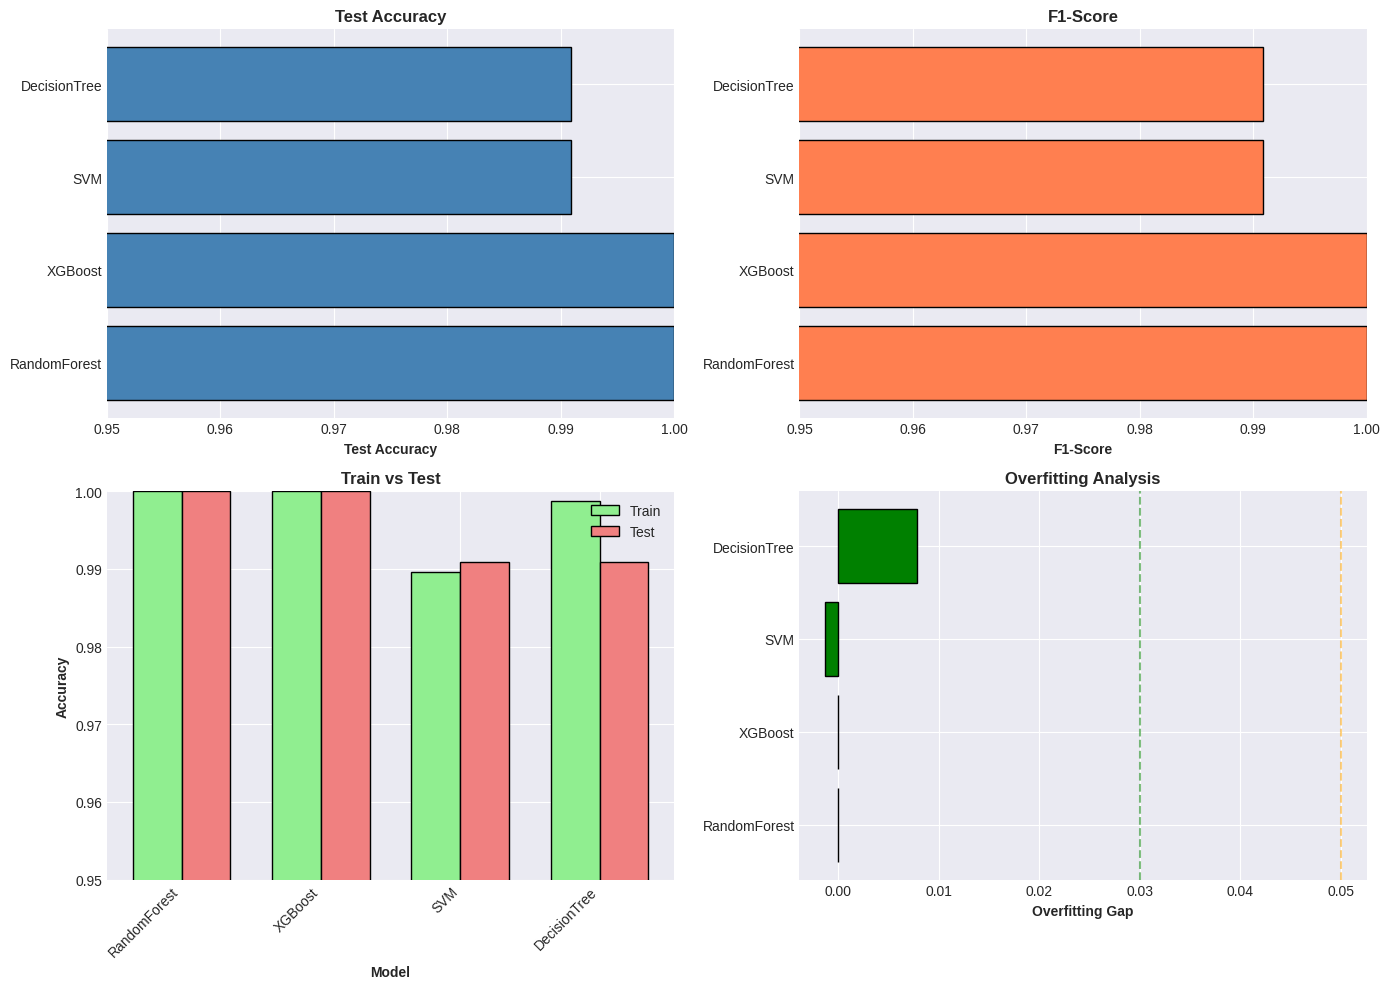

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Test Accuracy
axes[0, 0].barh(final_df['Model'], final_df['Test'], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Test Accuracy', fontweight='bold')
axes[0, 0].set_title('Test Accuracy', fontweight='bold')
axes[0, 0].set_xlim([0.95, 1.0])

# F1-Score
axes[0, 1].barh(final_df['Model'], final_df['F1'], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('F1-Score', fontweight='bold')
axes[0, 1].set_title('F1-Score', fontweight='bold')
axes[0, 1].set_xlim([0.95, 1.0])

# Train vs Test
x = np.arange(len(final_df))
width = 0.35
axes[1, 0].bar(x - width/2, final_df['Train'], width, label='Train', color='lightgreen', edgecolor='black')
axes[1, 0].bar(x + width/2, final_df['Test'], width, label='Test', color='lightcoral', edgecolor='black')
axes[1, 0].set_xlabel('Model', fontweight='bold')
axes[1, 0].set_ylabel('Accuracy', fontweight='bold')
axes[1, 0].set_title('Train vs Test', fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(final_df['Model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].set_ylim([0.95, 1.0])

# Overfitting Gap
colors = ['green' if g < 0.03 else 'orange' if g < 0.05 else 'red' for g in final_df['Gap']]
axes[1, 1].barh(final_df['Model'], final_df['Gap'], color=colors, edgecolor='black')
axes[1, 1].set_xlabel('Overfitting Gap', fontweight='bold')
axes[1, 1].set_title('Overfitting Analysis', fontweight='bold')
axes[1, 1].axvline(x=0.03, color='green', linestyle='--', alpha=0.5)
axes[1, 1].axvline(x=0.05, color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# **SAVE BEST MODEL**

In [83]:
os.makedirs('deployment', exist_ok=True)

joblib.dump(best_model, f'deployment/best_model_{best_model_name}.pkl')
joblib.dump(scaler, 'deployment/scaler.pkl')
joblib.dump(top_10_features, 'deployment/feature_names.pkl')
joblib.dump(label_encoder, 'deployment/label_encoder.pkl')

# Save metadata
metadata = {
    'model_name': best_model_name,
    'test_accuracy': float(best_test_acc),
    'features': top_10_features,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('deployment/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Best model saved: {best_model_name}")
print(f"Test Accuracy: {best_test_acc*100:.2f}%")

Best model saved: XGBoost
Test Accuracy: 100.00%


View experiments: https://dagshub.com/selvia.nasser19/crop-recommendation

# **💡 Key Insights**


---


*   XGBoost consistently outperformed all other models.
*   Random Forest performed well but slightly less accurate.


*   SVM improved notably after tuning but still behind XGBoost.
*   Decision Tree was simplest but less generalizable.

# Recommendation System

In [84]:
import numpy as np
import pandas as pd

def recommend_crops(best_model, label_encoder, scaler):
    print("🌱 Please enter soil and environmental data:\n")

    # Step 1 — user input (raw features only)
    N = float(input("Enter Nitrogen value (N): "))
    P = float(input("Enter Phosphorus value (P): "))
    K = float(input("Enter Potassium value (K): "))
    temperature = float(input("Enter Temperature (°C): "))
    humidity = float(input("Enter Humidity (%): "))
    ph = float(input("Enter pH value: "))
    rainfall = float(input("Enter Rainfall (mm): "))

    # Step 2 — feature engineering (same as training)
    user_input = pd.DataFrame([{
        'temp_rain': temperature * rainfall,
        'ph_rain': ph * rainfall,
        'K': K,
        'rainfall': rainfall,
        'N': N,
        'P': P,
        'NPK_Avg_Soil_Fertility': (N + P + K) / 3,
        'humidity': humidity,
        'NP_Ratio': N / P if P != 0 else 0,
        'THI': (temperature * humidity) / 100
    }])

    print("\n✅ Processed Input for Model:")
    print(user_input)

    # Step 3 — prediction
    user_input_scaled = scaler.transform(user_input)
    probs = best_model.predict_proba(user_input_scaled)[0]
    encoded_labels = best_model.classes_
    crop_labels = label_encoder.inverse_transform(encoded_labels)

    # ✅ Only the top crop
    top_index = probs.argmax()
    top_crop = crop_labels[top_index]
    top_prob = probs[top_index] * 100

    print("\n🌾 Recommended Crop:")
    print(f"→ {top_crop} (Suitability: {top_prob:.2f}%)")


In [85]:
recommend_crops(best_model, label_encoder, scaler)

🌱 Please enter soil and environmental data:

Enter Nitrogen value (N): 22
Enter Phosphorus value (P): 133
Enter Potassium value (K): 200
Enter Temperature (°C): 23
Enter Humidity (%): 87
Enter pH value: 5.98
Enter Rainfall (mm): 90

✅ Processed Input for Model:
   temp_rain  ph_rain      K  rainfall     N      P  NPK_Avg_Soil_Fertility  \
0     2070.0    538.2  200.0      90.0  22.0  133.0              118.333333   

   humidity  NP_Ratio    THI  
0      87.0  0.165414  20.01  

🌾 Recommended Crop:
→ apple (Suitability: 96.13%)


# **🌾 Example Prediction**


---



*Input:* N=22, P=133, K=200, Temp=23°C, Humidity=87%, pH=5.98, Rainfall=90 mm

*Predicted Crop:* 🍎 **Apple**

*Suitability:* **96.13%**

In [86]:
from google.colab import files

files.download("/content/deployment/best_model_XGBoost.pkl")
files.download("/content/deployment/scaler.pkl")
files.download("/content/deployment/feature_names.pkl")
files.download("/content/deployment/label_encoder.pkl")

files.download("deployment/metadata.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>